## this notebook is for a DS testing task, the main goal is to predict the conversion rate/probability after ads impression, 
### here is the task text in russian:
Для рекламной сети важно уметь точно предсказывать вероятность совершения пользователем
конверсии (conversion) на каждый показ (impression) определенной рекламного банера.
По предложенной выборке данных необходимо произвести оценку значимости различных 
факторов для решения данной задачи



firstly you may install the requirement from the provided file:
```
pip install -r requirements.txt
```

In [ ]:
pip install -r requirements.txt

In [ ]:
 # autotime package for execution time calulation for each cell
 %load_ext autotime

lets import the needed libraries and filter unused Pandas warnings

In [2]:
import pandas as pd
import warnings
from typing import List
import glob
import functools
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option('mode.chained_assignment', None)

we read the provided csv file containing 1 million data of ads impression/conversion history for different targettings/features\
we splited the data into chunks so we can upload it to Github

In [18]:
def read_csv_file(path: str, sep: 'str') -> pd.DataFrame:
    return pd.concat(map(functools.partial(pd.read_csv, sep=sep),
                    glob.glob("{}/*.csv".format(path)))).reset_index(drop=True)

data_path = 'data'
data = read_csv_file(data_path, sep='|')
data.head(3).append(data.tail(3))

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions
0,2016-09-14 13:00:00,23449129.0,449740.0,NaN,10806667.0,4082117.0,PT,15518.0,25222.0,1.0,desktop,windows,win10,desktop,desktop,chrome,pt,0.0,0.0,0.0,1627.0,f,MOBILE,1.0,0.0
1,2016-09-08 21:00:00,18295266.0,17528.0,NaN,8530972.0,2137696.0,EG,25289.0,1184.0,1.0,desktop,windows,win8,desktop,desktop,chrome,en,2.0,0.0,102851.0,0.0,f,BROADBAND,1.0,0.0
2,2016-09-08 23:00:00,22922459.0,357095.0,NaN,1667935.0,690594.0,IN,9999.0,10358.0,1.0,desktop,windows,win7,desktop,desktop,firefox,en,11.0,0.0,62891.0,0.0,f,BROADBAND,1.0,0.0
999998,2016-09-11 03:00:00,2502619.0,25334.0,NaN,6548799.0,3302309.0,GB,25512.0,22859.0,1.0,desktop,windows,win10,desktop,desktop,chrome,en,6.0,0.0,115130.0,0.0,f,BROADBAND,1.0,0.0
999999,2016-09-11 08:00:00,20522087.0,368197.0,NaN,13014907.0,25560.0,PL,14360.0,42626.0,1.0,desktop,windows,win10,desktop,desktop,firefox,pl,1.0,0.0,35105.0,0.0,f,BROADBAND,1.0,0.0
1000000,(1000000 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we take a look at data info to get an idea of column, null values, and data type

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date_time      1000001 non-null  object 
 1   banner_id      1000000 non-null  float64
 2   advertiser_id  1000000 non-null  float64
 3   offer_id       392841 non-null   float64
 4   zone_id        1000000 non-null  float64
 5   affiliate_id   1000000 non-null  float64
 6   geo            999926 non-null   object 
 7   region_code    1000000 non-null  float64
 8   city_code      1000000 non-null  float64
 9   varp           1000000 non-null  float64
 10  os_type        1000000 non-null  object 
 11  os             1000000 non-null  object 
 12  os_version     1000000 non-null  object 
 13  device_type    1000000 non-null  object 
 14  device         1000000 non-null  object 
 15  browser        1000000 non-null  object 
 16  lang           1000000 non-null  object 
 17  varpp   

lets set some global variable, to be used in different steps 

In [5]:
date_column = 'date_time'
imps_column = 'impressions'
convs_column = 'conversions'
binary_convs_column = 'conversed'
conversion_rate_column = 'cr'
hour_column = 'hour'
day_column = 'day'
advertiser_column = 'advertiser_id'
binary_cols = ['proxy']
numerical_cols = ['varp', 'varpp', 'varcc']
categorical_cols = ['netspeed', 'lang', 'browser', 'device', 'device_type', 'os', 'os_type', 'os_version', 'geo']
model_exclud_columns = [date_column, imps_column, convs_column, binary_convs_column, conversion_rate_column,
                        advertiser_column]
id_cols = list(set(data.columns) - set(categorical_cols + binary_cols + numerical_cols + model_exclud_columns))


time: 992 µs (started: 2023-01-21 23:14:09 +04:00)


the date column is the one of the main indexes in the data, so lets validate and drop unwanted rows, like the last row above

In [6]:
def validate_date(data: pd.DataFrame, column: str) -> pd.DataFrame:
    mask = pd.to_datetime(data[column], errors='coerce').notna()
    data = data[mask]
    data[column] = pd.to_datetime(data[column])
    return data

data = validate_date(data, date_column)

time: 593 ms (started: 2023-01-21 23:14:09 +04:00)


we calculate converion rate by dividing n_rate/n_impressions \
the binary converssion columns means the fact of having at least one converrsion was made after n impressions

In [7]:
def calculate_conversion_rate(data: pd.DataFrame, imps_column: str, convs_column: str, conversion_rate_column: str,
                              binary_convs_column: str) -> pd.DataFrame:
    data[conversion_rate_column] = data.apply(
        lambda x: 100 * (float(x[convs_column]) / x[imps_column]
                         if x[imps_column] >= x[convs_column]
                         else min(x[convs_column], 1))
        , axis=1)
    data[binary_convs_column] = data[convs_column].apply(lambda x: 1 if x > 0 else 0)
    return data


data = calculate_conversion_rate(data, imps_column, convs_column, conversion_rate_column, binary_convs_column)

time: 18.1 s (started: 2023-01-21 23:14:09 +04:00)


if the n_conversion> n_impressions this as some kind of anomaly,\
it can be due to some tecknical bag, or more frequently to a fraud process\
also we can that the data is unbalanced with less one of 1% of impressions leaded to converssion

In [8]:
print('conversion rate annomality:')
print(len(data.query(convs_column + '>' + imps_column)) / len(data))
print('conversion binary ballance:')
print(((data[binary_convs_column].value_counts() / len(data)) * 100).to_frame())

conversion rate annomality:
0.0009
conversion binary ballance:
   conversed
0    99.6828
1     0.3172
time: 166 ms (started: 2023-01-21 23:14:28 +04:00)


## feature engineering
lets do it by steps based on the feature type \
we start by converting the features to the wanted type.

In [13]:
def features_type_processing(data: pd.DataFrame, numerical_cols: List[str], categorical_cols: List[str],
                             binary_cols: List[str], id_cols: List[str],
                             binary_true_values: List[str] = ['t', 'true', 'yes']):
    for col in numerical_cols:
        col_max = data[col].astype(float).max()
        data[col] = data[col].astype(float).apply(lambda x: x / col_max)
    for col in categorical_cols:
        data[col] = data[col].astype(str)
    for col in id_cols:
        data[col] = data[col].fillna(-1).astype(int)
    for col in binary_cols:
        data[col] = data[col].apply(lambda x: 1 if str(x).lower() in binary_true_values else 0).astype(int)
    return data


data = features_type_processing(data, numerical_cols, categorical_cols, binary_cols, id_cols)
data.head(3)

,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions,cr,conversed
0,2016-09-09 10:00:00,23051597,502713.0,492,4375553,2505762,BR,726,4162,1.00,mobile,android,android5,tablet,other,fb,pt,0.04,0.0,17111,0,0,BROADBAND,1.0,0.0,0.0,0
1,2016-09-05 14:00:00,23075994,8508.0,2287,13732852,6530828,RO,12074,512299,0.25,desktop,windows,win7,desktop,desktop,chrome,ro,0.08,0.0,88118,0,0,BROADBAND,1.0,0.0,0.0,0
2,2016-09-08 22:00:00,21359300,17528.0,-1,12242731,5797966,EG,25295,29514,1.00,mobile,android,android6,tablet,other,chrome,en,0.24,0.0,102851,0,0,BROADBAND,1.0,0.0,0.0,0


time: 2.58 s (started: 2023-01-21 23:14:38 +04:00)


## Numerical features

In [9]:
data[numerical_cols].describe()

,varp,varpp,varcc
count,1000000.000000,1000000.000000,1000000.000000
mean,2.275994,7.402995,3.362308
std,1.428842,35.712483,21.130401
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,2.000000,0.000000
75%,4.000000,5.000000,1.000000
max,5.000000,6772.000000,1644.000000


time: 140 ms (started: 2023-01-21 23:14:28 +04:00)


we see from the description table the existing of outliers for the numirical features, lets drop them

In [10]:
def numerical_outliers_droping(data: pd.DataFrame, numerical_cols: List[str],
                               quantiles: List[float] = [0.05, 0.95]) -> pd.DataFrame:
    data[numerical_cols] = data[numerical_cols].apply(lambda x: x.clip(*x.quantile(quantiles)))
    return data


data = numerical_outliers_droping(data, numerical_cols)

time: 180 ms (started: 2023-01-21 23:14:28 +04:00)


lets draw the violin plot to look at the values distribution based on converssion for each feature separately,\
and take an idea at the features impact on conversion

<AxesSubplot: xlabel='variable', ylabel='value'>

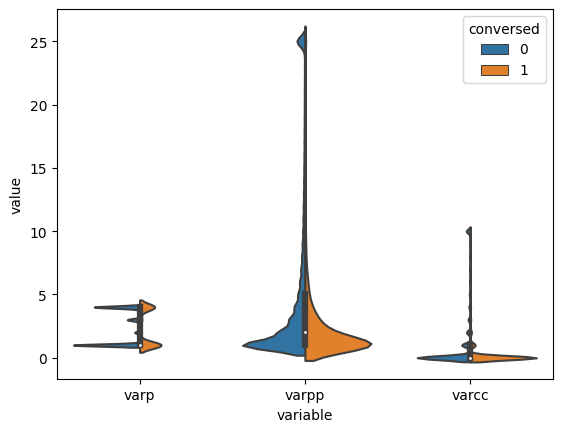

time: 8.63 s (started: 2023-01-21 23:14:28 +04:00)


In [11]:
import seaborn as sns

sns.violinplot(data=data.melt(id_vars=binary_convs_column, value_vars=numerical_cols),
               x='variable', y='value', hue=binary_convs_column, split=True)

## categorical values analisys 

In [12]:
for col in categorical_cols:
    value_counts = data[col].value_counts().to_frame()
    print(col + ' | unique values count: ', data[col].nunique())
    print(value_counts.head(2).append(value_counts.tail(2)))

netspeed | unique values count:  10
           netspeed
BROADBAND    497959
MOBILE       188324
-                67
T3                3
lang | unique values count:  111
      lang
en  525699
fr  106238
nv       1
st       1
browser | unique values count:  13
        browser
chrome   613545
safari    90960
yandex      291
puffin      144
device | unique values count:  8
         device
desktop  534868
other    356399
ipod       1535
kindle        8
device_type | unique values count:  5
         device_type
desktop       534868
phone         280583
tv             15212
other             19
os | unique values count:  9
                os
windows     495984
android     343179
blackberry    1337
symbian        615
os_type | unique values count:  3
         os_type
desktop   552326
mobile    447655
mobile    447655
other         19
os_version | unique values count:  28
                os_version
win7                226281
win10               161025
android3                93
windows_phone7  

we calculate values effect on the convertion by feature,\
the values with low afffect on conversion will be saved for later use

In [14]:
def draw_values_conversion_ratio(data: pd.DataFrame, columns: str, binary_convs_column: str, draw: bool) -> dict:
    results = {}
    tmp = data.melt(id_vars=binary_convs_column, value_vars=columns, var_name='column').\
        groupby(['column', 'value'], as_index=False).\
        agg({binary_convs_column: {'sum', 'count'}})
    tmp.columns = ['column'] + ['_'.join(col) for col in tmp.columns.values[1:]]
    tmp[binary_convs_column] = (tmp[binary_convs_column + '_sum'] / tmp[binary_convs_column + '_count'])
    for col in tmp['column'].unique():
        value_by_col = tmp.query('column==@col')
        quantile = value_by_col[binary_convs_column].quantile([0.3]).values[0]
        if draw:
            value_by_col.plot.bar(x='value_',
                                  y=binary_convs_column,
                                  title='{} values conversion relation'.format(col),
                                  figsize=[20, 3])
        results[col] = value_by_col.query(binary_convs_column + '<=@quantile')['value_'].unique().tolist()
    return results


grouping_values = draw_values_conversion_ratio(data, categorical_cols + id_cols, binary_convs_column, False)


time: 5.32 s (started: 2023-01-21 23:14:41 +04:00)


we draw the histograme of values effect on the convertion for categotical features

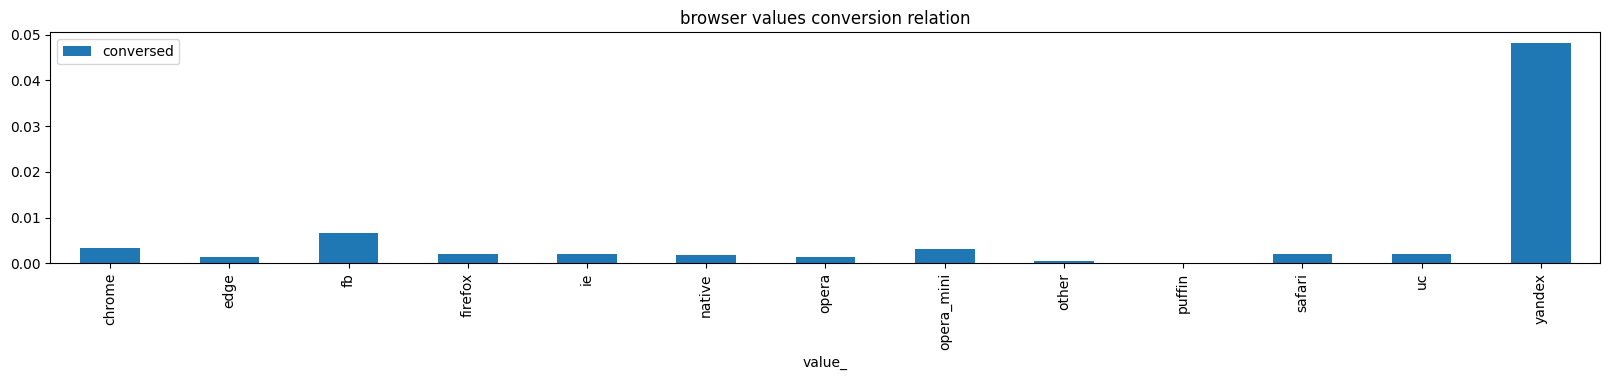

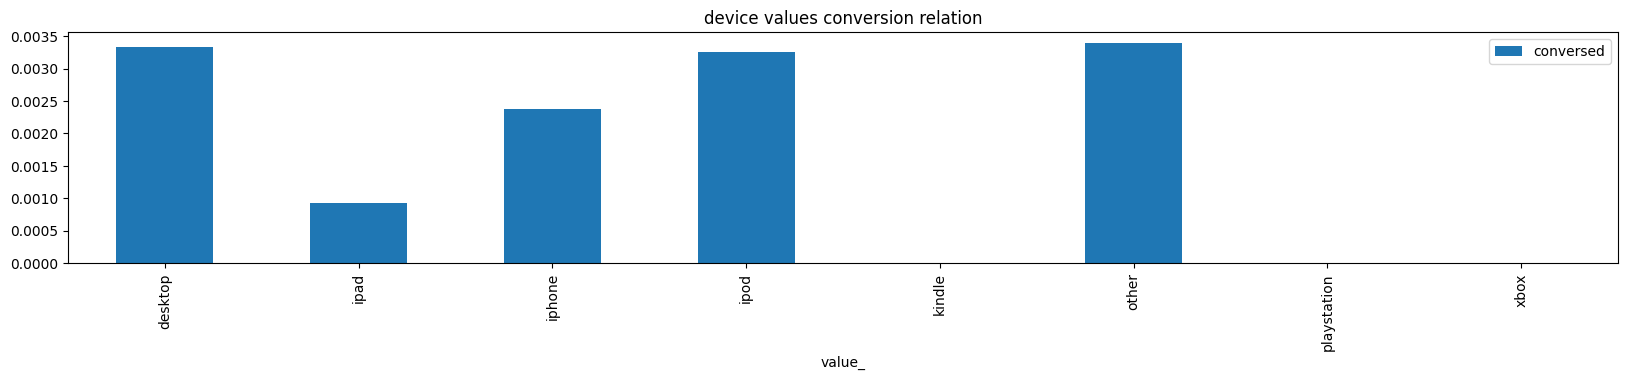

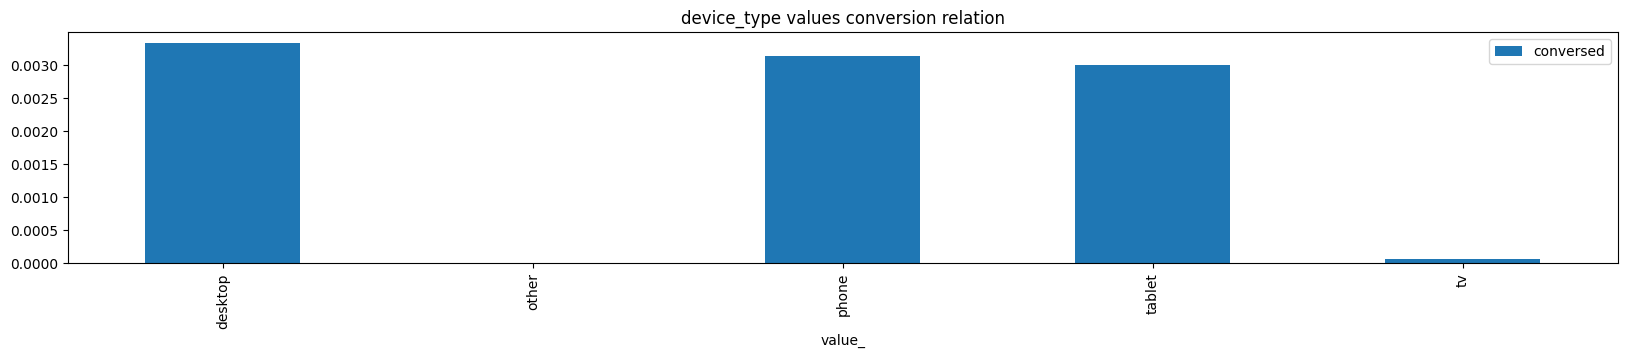

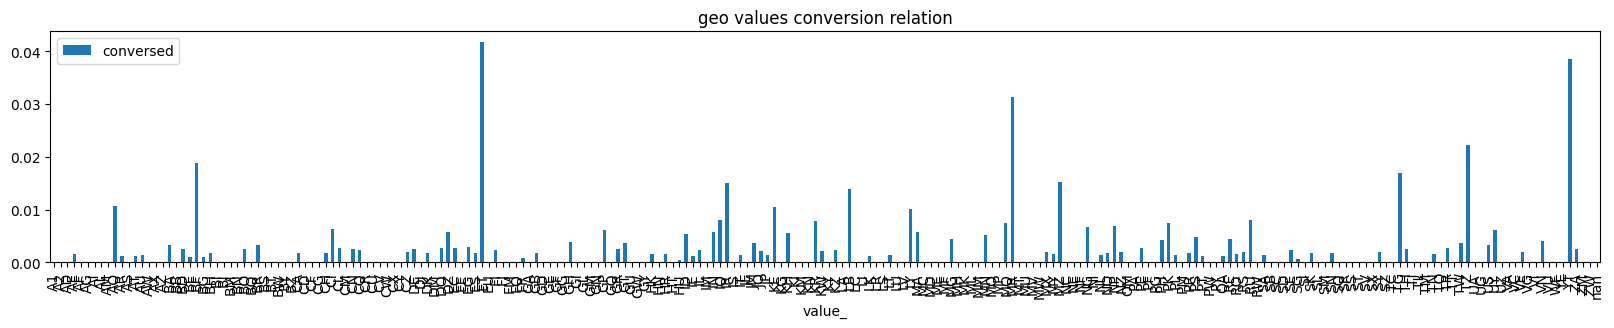

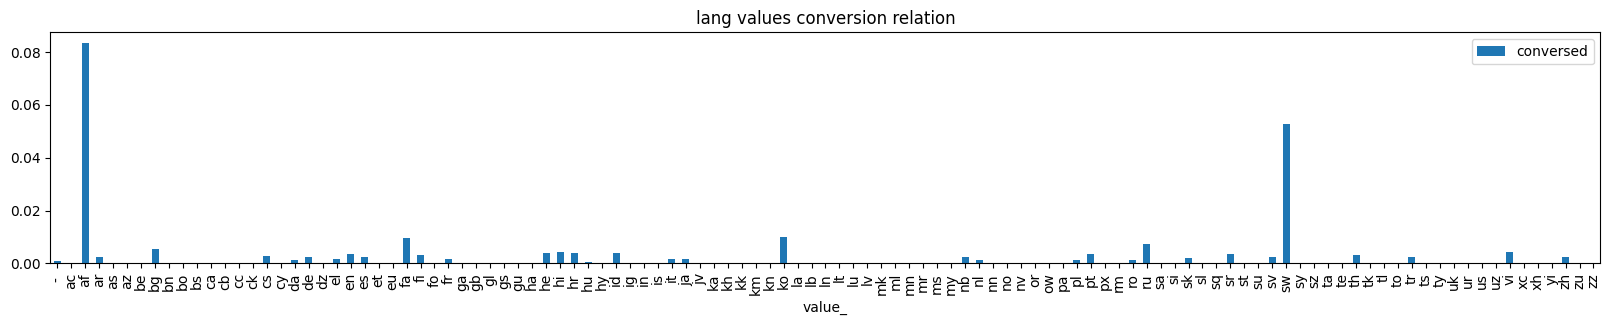

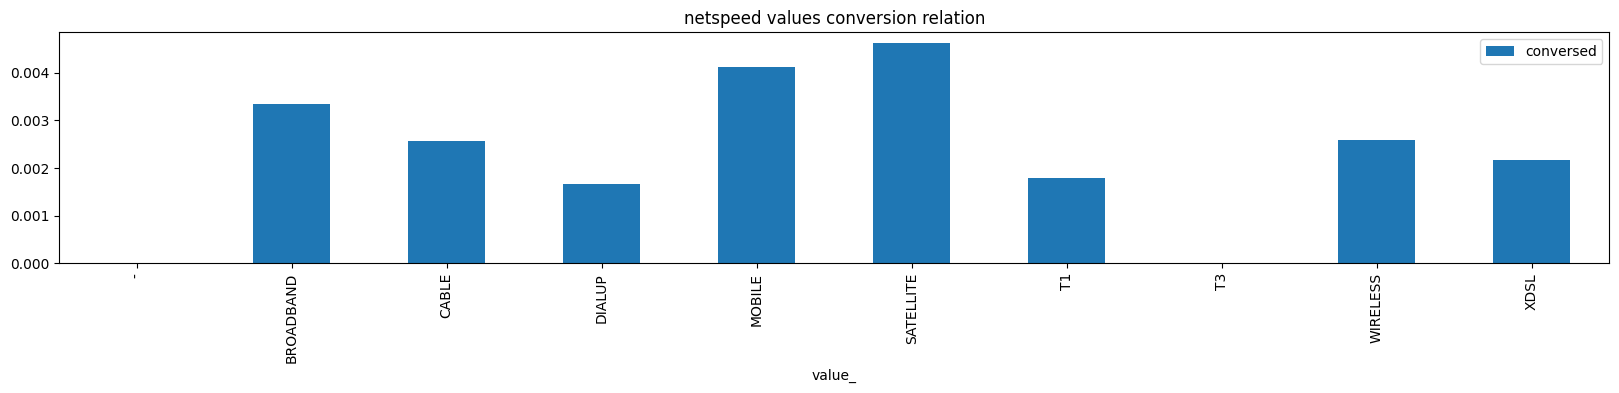

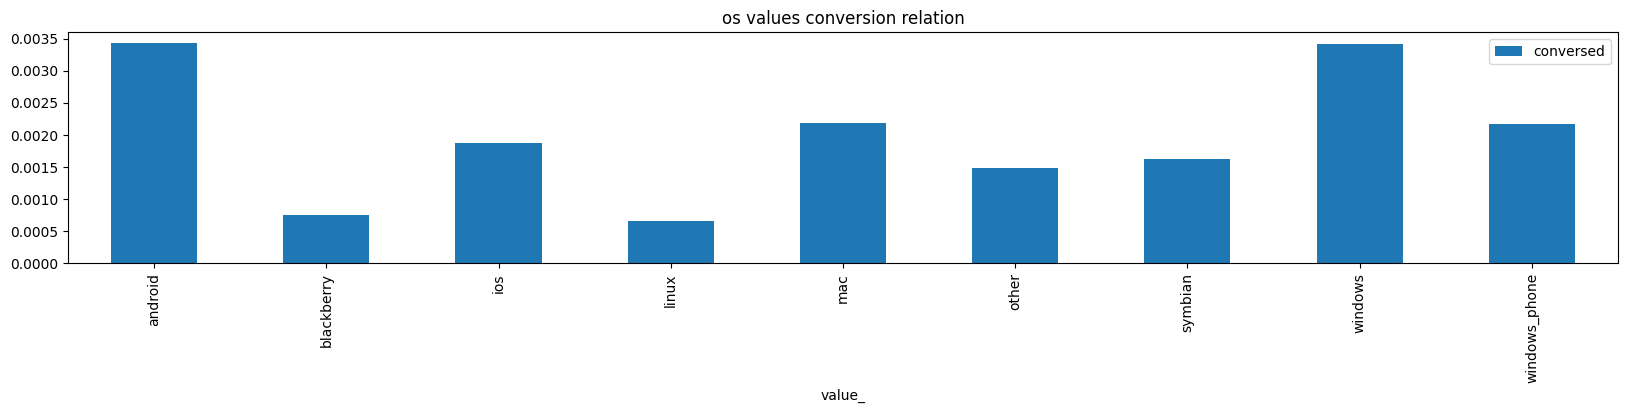

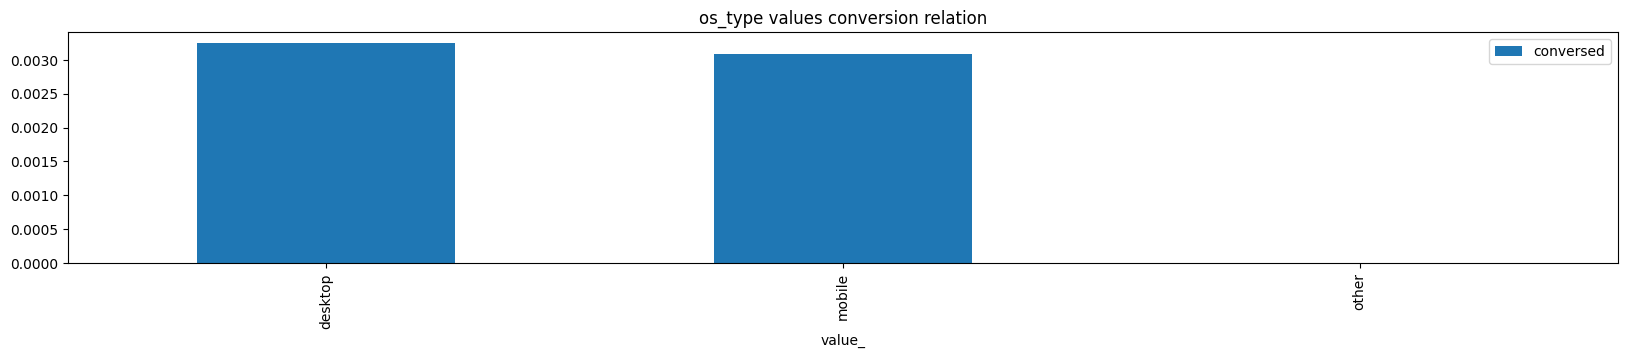

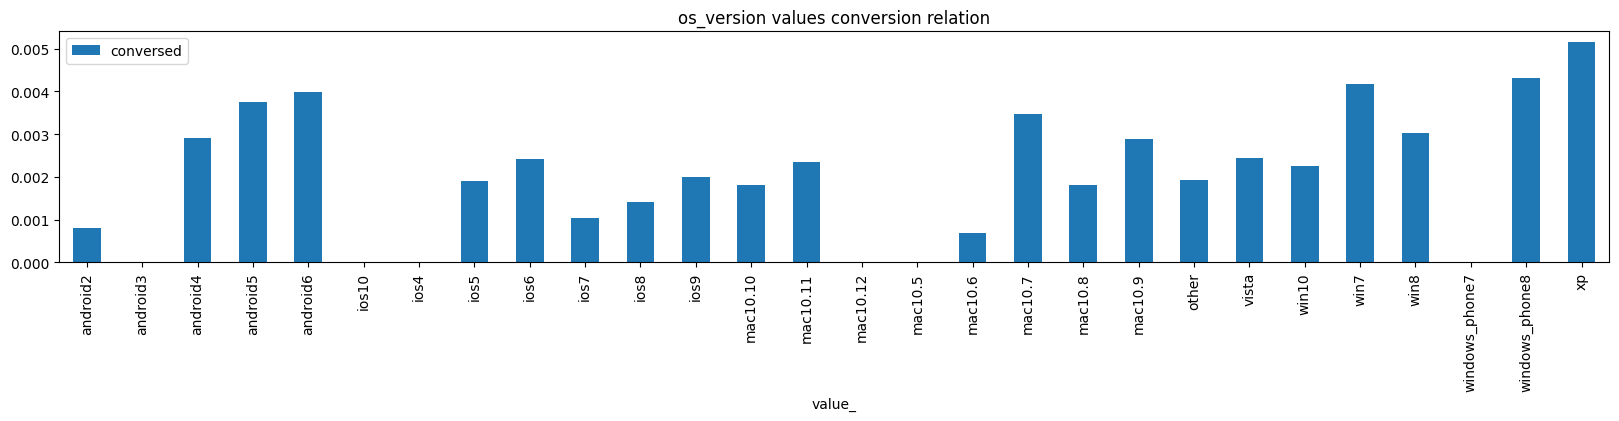

time: 7.19 s (started: 2023-01-21 23:14:46 +04:00)


In [15]:
_ = draw_values_conversion_ratio(data, categorical_cols, binary_convs_column, True)

## binary features

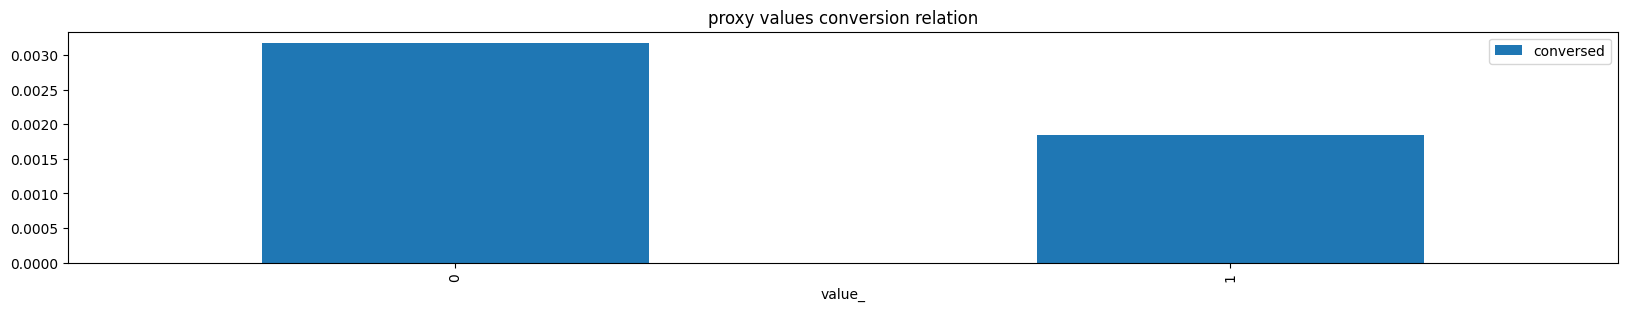

time: 445 ms (started: 2023-01-22 18:54:48 +04:00)


In [64]:
_ = draw_values_conversion_ratio(data, binary_cols, binary_convs_column, True)

## date feature
lets draw impression/ conversion by data, to see if there is any seasonality/trend

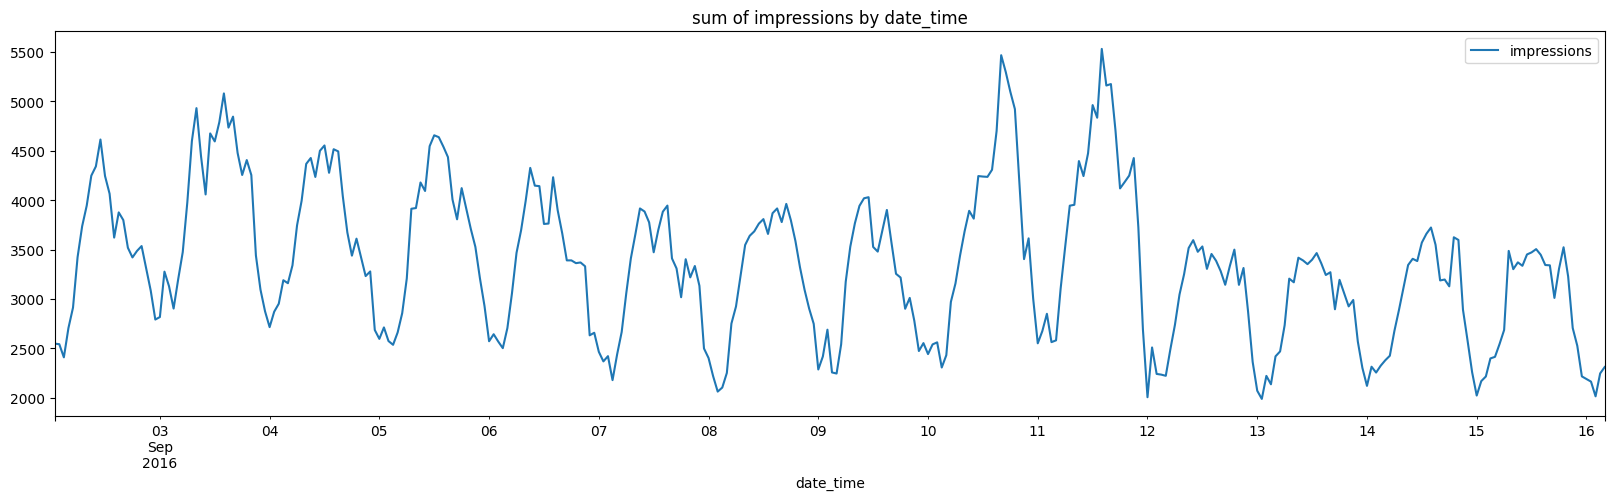

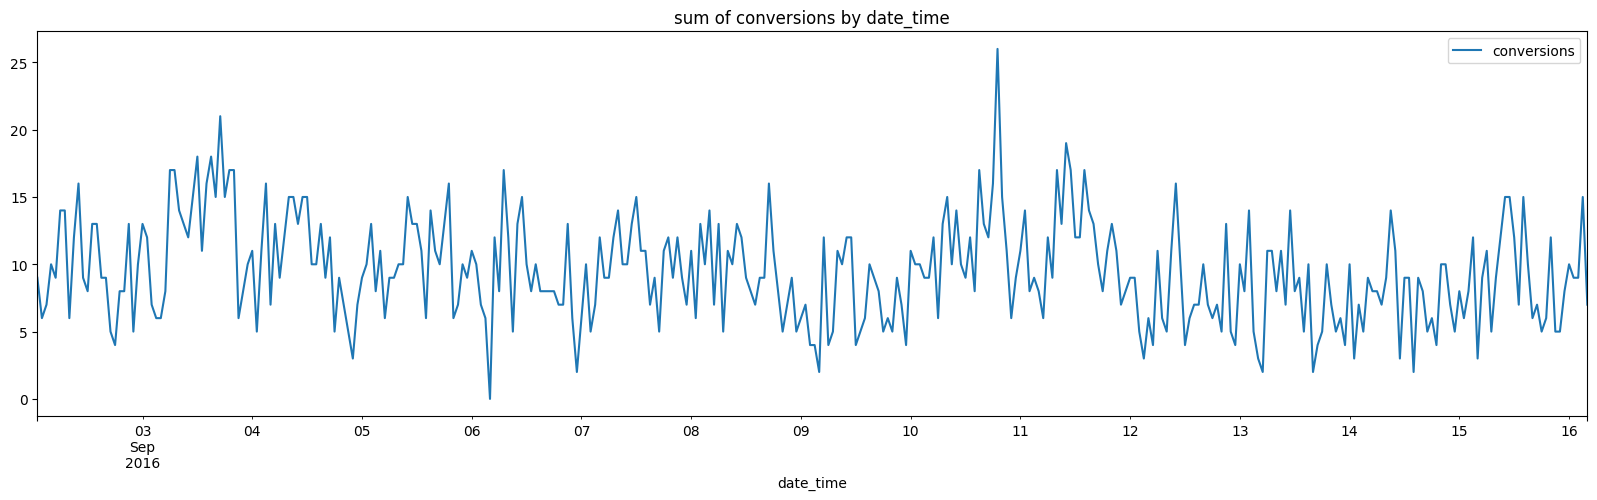

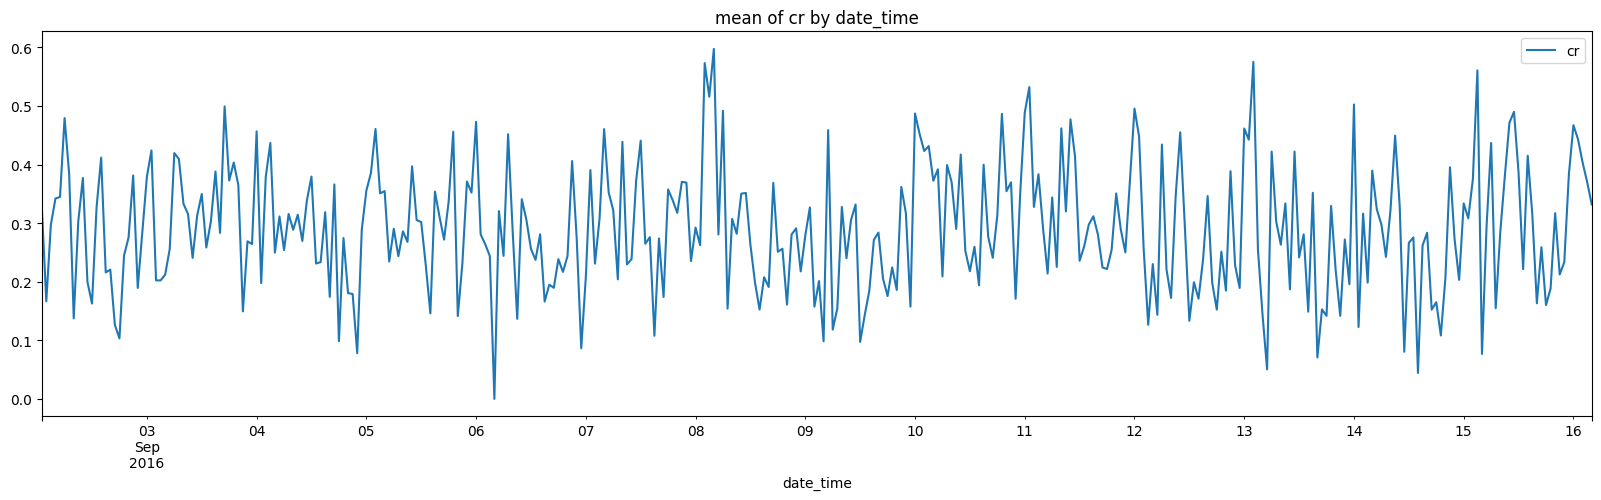

time: 1.15 s (started: 2023-01-21 23:14:53 +04:00)


In [17]:
def plot_value_by_date(data, date_column, value_column, agg_function):
    data.groupby(date_column, as_index=False).\
        agg({value_column: agg_function}).plot(
        x=date_column,
        y=value_column,
        figsize=[20, 5],
        title='{} of {} by {}'.format(agg_function, value_column, date_column)
    )


plot_value_by_date(data, date_column, imps_column, 'sum')
plot_value_by_date(data, date_column, convs_column, 'sum')
plot_value_by_date(data, date_column, conversion_rate_column, 'mean')


for the impressions the seasonality is clear, the random state for corvertion rate is high,\
so lets extract day/hour value and see the relation

In [18]:
from pandas.api.types import CategoricalDtype


def day_hours_extracter(data: pd.DataFrame, hour_column: str, day_column: str) -> pd.DataFrame:
    days_sorted = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_sorted = CategoricalDtype(categories=days_sorted, ordered=True)
    data[hour_column] = data[date_column].apply(lambda x: x.hour)
    data[day_column] = data[date_column].apply(lambda x: x.day_name()).astype(days_sorted)
    return data


data = day_hours_extracter(data, hour_column, day_column)
data.head(2).append(data.tail(2))


,date_time,banner_id,advertiser_id,offer_id,zone_id,affiliate_id,geo,region_code,city_code,varp,os_type,os,os_version,device_type,device,browser,lang,varpp,varcc,isp,mobile_isp,proxy,netspeed,impressions,conversions,cr,conversed,hour,day
0,2016-09-09 10:00:00,23051597,502713.0,492,4375553,2505762,BR,726,4162,1.00,mobile,android,android5,tablet,other,fb,pt,0.04,0.0,17111,0,0,BROADBAND,1.0,0.0,0.0,0,10,Friday
1,2016-09-05 14:00:00,23075994,8508.0,2287,13732852,6530828,RO,12074,512299,0.25,desktop,windows,win7,desktop,desktop,chrome,ro,0.08,0.0,88118,0,0,BROADBAND,1.0,0.0,0.0,0,14,Monday
999998,2016-09-11 03:00:00,2502619,25334.0,-1,6548799,3302309,GB,25512,22859,0.25,desktop,windows,win10,desktop,desktop,chrome,en,0.24,0.0,115130,0,0,BROADBAND,1.0,0.0,0.0,0,3,Sunday
999999,2016-09-11 08:00:00,20522087,368197.0,-1,13014907,25560,PL,14360,42626,0.25,desktop,windows,win10,desktop,desktop,firefox,pl,0.04,0.0,35105,0,0,BROADBAND,1.0,0.0,0.0,0,8,Sunday


time: 7.19 s (started: 2023-01-21 23:14:55 +04:00)


ploting the conversion/impression changes by days/ hours\
shows different between weekend/week days and day/night hours\
so lets keep the added features for now

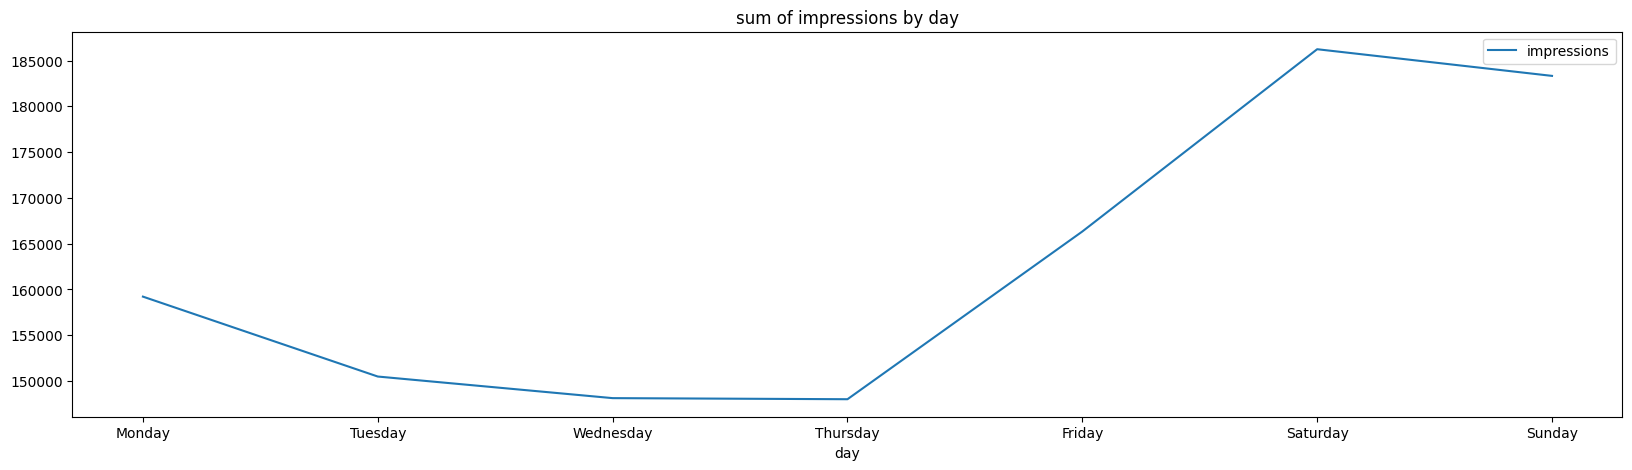

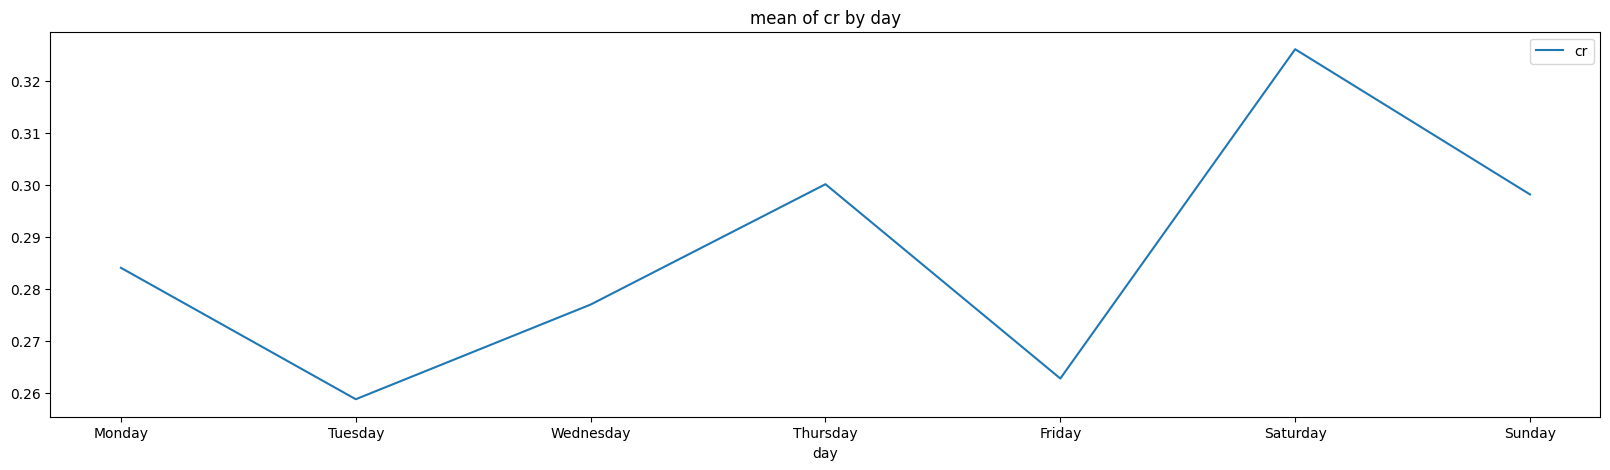

time: 665 ms (started: 2023-01-21 23:15:02 +04:00)


In [19]:
plot_value_by_date(data, day_column, imps_column, 'sum')
plot_value_by_date(data, day_column, conversion_rate_column, 'mean')

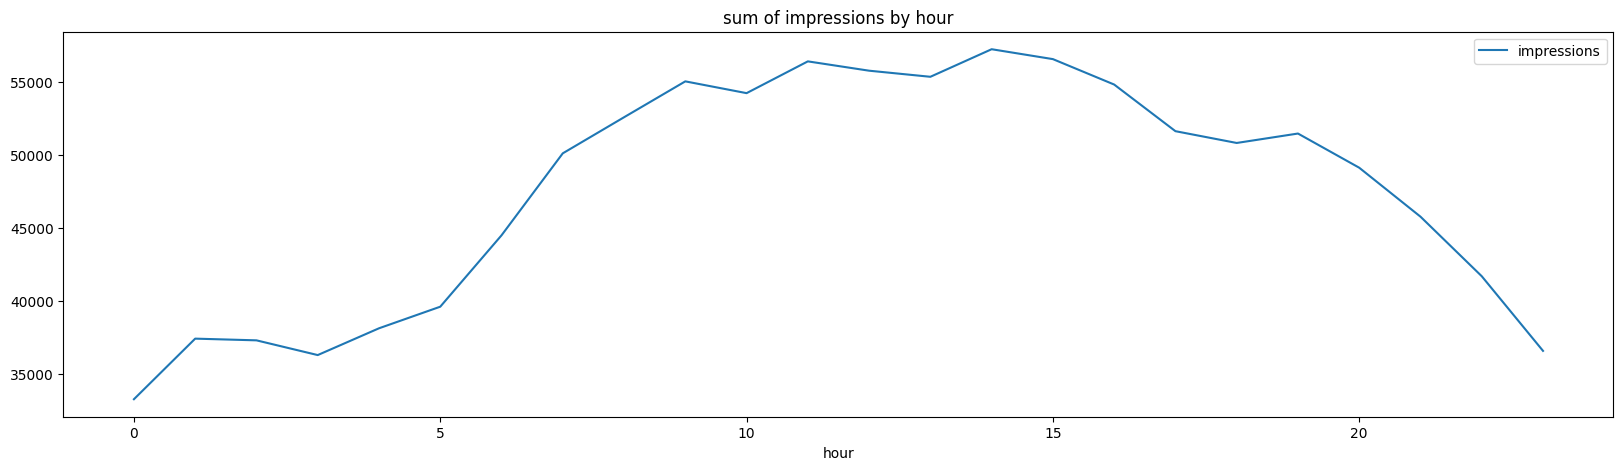

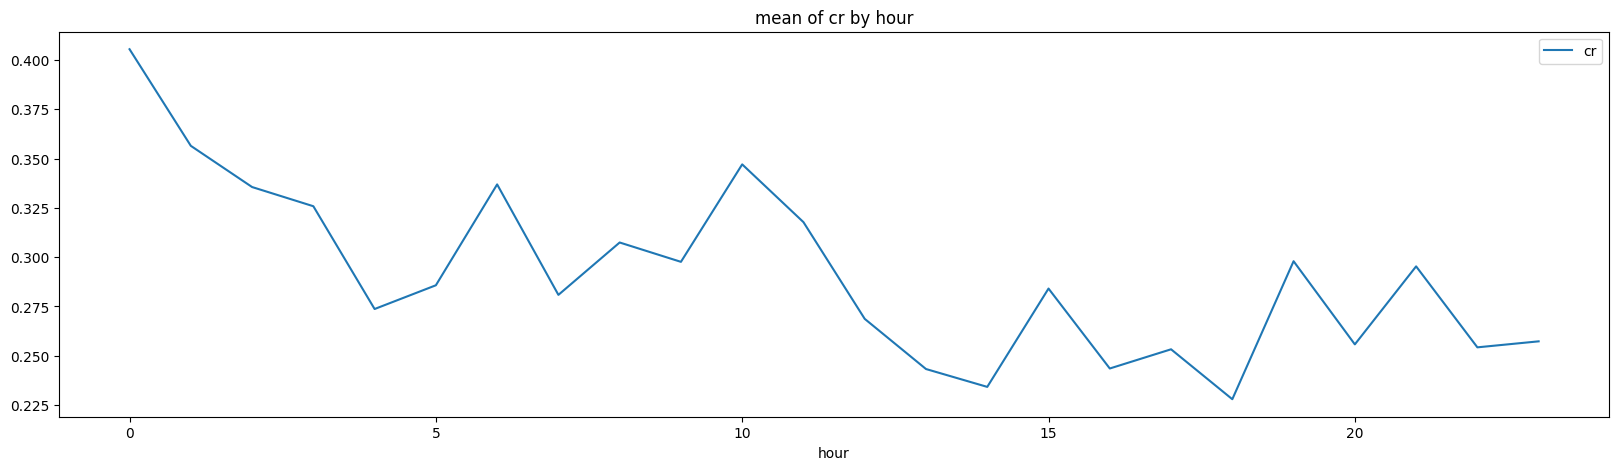

time: 621 ms (started: 2023-01-21 23:15:03 +04:00)


In [20]:
plot_value_by_date(data, hour_column, imps_column, 'sum')
plot_value_by_date(data, hour_column, conversion_rate_column, 'mean')

## ordinal features

lets verify the cardinality for diferent columns and draw the correlation matrix to see if there is a direct relation between the features and the effect on conversion

In [21]:
for col in id_cols:
    print(col + ' | unique values count: ', data[col].nunique())
data[id_cols + numerical_cols + [hour_column, binary_convs_column]].corr().style.background_gradient(cmap='coolwarm')

banner_id | unique values count:  8083
isp | unique values count:  10493
city_code | unique values count:  39699
offer_id | unique values count:  664
region_code | unique values count:  2362
affiliate_id | unique values count:  97
mobile_isp | unique values count:  433
zone_id | unique values count:  100


,banner_id,isp,city_code,offer_id,region_code,affiliate_id,mobile_isp,zone_id,varp,varpp,varcc,hour,conversed
banner_id,1.000000,-0.056961,0.009162,0.142177,-0.062871,0.232111,0.034034,0.080334,0.131321,-0.113733,-0.271546,-0.012378,0.005124
isp,-0.056961,1.000000,0.008998,-0.008877,0.083238,-0.028988,0.018228,-0.010499,-0.004181,0.020079,0.049885,0.009552,-0.001530
city_code,0.009162,0.008998,1.000000,-0.010418,0.105880,-0.064942,-0.080322,0.010125,-0.046560,-0.004403,-0.018709,-0.054514,-0.000795
offer_id,0.142177,-0.008877,-0.010418,1.000000,-0.031849,0.108235,0.041202,0.034395,0.122212,-0.043247,-0.039217,-0.017515,-0.006509
region_code,-0.062871,0.083238,0.105880,-0.031849,1.000000,-0.176751,-0.024859,-0.165999,-0.115139,0.077761,0.074080,-0.123540,-0.000037
affiliate_id,0.232111,-0.028988,-0.064942,0.108235,-0.176751,1.000000,0.058945,0.506769,0.173778,-0.069197,-0.037604,0.027339,0.005307
mobile_isp,0.034034,0.018228,-0.080322,0.041202,-0.024859,0.058945,1.000000,-0.052385,0.297054,-0.061741,0.006066,-0.010252,0.006728
zone_id,0.080334,-0.010499,0.010125,0.034395,-0.165999,0.506769,-0.052385,1.000000,0.018598,-0.043432,-0.048632,0.044664,-0.004971
varp,0.131321,-0.004181,-0.046560,0.122212,-0.115139,0.173778,0.297054,0.018598,1.000000,-0.187383,-0.008537,-0.007840,-0.000477
varpp,-0.113733,0.020079,-0.004403,-0.043247,0.077761,-0.069197,-0.061741,-0.043432,-0.187383,1.000000,0.265257,0.007053,-0.022853


time: 838 ms (started: 2023-01-21 23:15:03 +04:00)


## Catboost Training 
we choosed catboost since it work with categorical features without any pre-encoding/embeding\
first we train a naive model with all the features, without any processing\
since the data is umbalanced we setted ```'auto_class_weights':'Balanced'``` \
the eveluation metric is ```'eval_metric':'AUC'``` 'Area under curve' wich represent \
the separability of the classes classification, the higher the better, and works very good with umbalanced datasets\
and for loss function ```'loss_function':'Logloss',``` cross-entropy which  means the negative log-likelihood between the model prediction and the true value,\
and works good for binary classification the less is good\
other params as l2 regression,tree depth,lr,itteration are randomly choosen

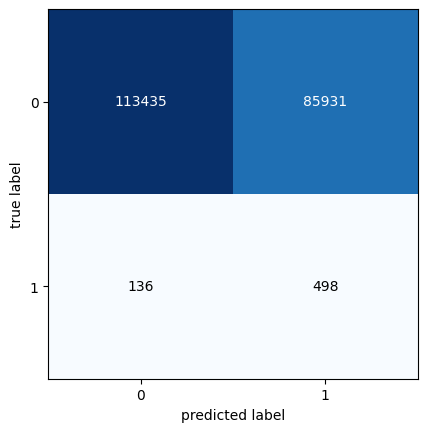

{'learn': {'Logloss': 0.6116453368926715}, 'validation': {'Logloss': 0.6187237959244204, 'AUC': 0.7545716015985184}}
time: 29.4 s (started: 2023-01-21 23:15:04 +04:00)


In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

params = {'iterations': 100,
          'learning_rate': 0.01,
          'depth': 5,
          'random_strength': 1,
          'cat_features': categorical_cols + [day_column],
          'auto_class_weights': 'Balanced',
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'od_type': "Iter",
          'verbose': 200,
          'od_wait': 30,
          'random_seed': 42,
          'l2_leaf_reg': 10
          }


def train_evaluate_model(data: pd.DataFrame, params: dict, model_exclud_columns: List[str], binary_convs_column: str,
                         plot: bool = True) -> CatBoostClassifier:
    X_train, X_test, y_train, y_test = train_test_split(data.drop(model_exclud_columns, axis=1),
                                                        data[binary_convs_column],
                                                        stratify=data[binary_convs_column],
                                                        test_size=0.2)
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(X_train, y_train,
                  eval_set=(X_test, y_test),
                  use_best_model=True, verbose=False
                  )
    if plot:
        fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, cat_model.predict(X_test, )))
        plt.show()
    return cat_model


naive_model = train_evaluate_model(data, params, model_exclud_columns, binary_convs_column)

we see from the confusing metrics above that the model generate a lot of false positives,\
lets take a look at the feature importance of the trained model

In [24]:
from catboost import Pool


def get_important_features_list(model: CatBoostClassifier, data: pd.DataFrame, model_exclud_columns: List[str],
                                categorical_cols: List[str], binary_convs_column: str, thresh: float = 0) -> List[
    'str']:
    X_train, X_test, y_train, y_test = train_test_split(data.drop(model_exclud_columns, axis=1),
                                                        data[binary_convs_column],
                                                        stratify=data[binary_convs_column],
                                                        test_size=0.2)
    results = []
    feature_importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_cols))
    feature_names = X_train.columns
    for score, name in sorted(zip(feature_importances, feature_names), reverse=False):
        print('column: {}| importance {}'.format(name, score))
        if score > thresh:
            results.append(name)
    print('column: importance')
    return results


naive_important_features = get_important_features_list(naive_model, data, model_exclud_columns,
                                                       categorical_cols + [day_column], binary_convs_column)


column: day| importance 0.0
column: geo| importance 0.0
column: lang| importance 0.0
column: proxy| importance 0.05310338043220053
column: city_code| importance 0.12880006008955477
column: isp| importance 0.23545536962634764
column: hour| importance 0.33246034853086437
column: os_type| importance 0.4036002872547702
column: netspeed| importance 0.5670686571286425
column: mobile_isp| importance 0.6288747307143278
column: os_version| importance 0.9822240062880785
column: varp| importance 1.4118779989365888
column: region_code| importance 1.4325024090568375
column: device_type| importance 1.9227955713343705
column: browser| importance 2.091032128021448
column: os| importance 3.2900767348243614
column: zone_id| importance 4.334043179484091
column: device| importance 4.947489137697724
column: banner_id| importance 5.17367427765721
column: offer_id| importance 6.725073313762895
column: affiliate_id| importance 14.17527564994563
column: varpp| importance 21.602579813498497
column: varcc| impor

let draw the histogram of importance

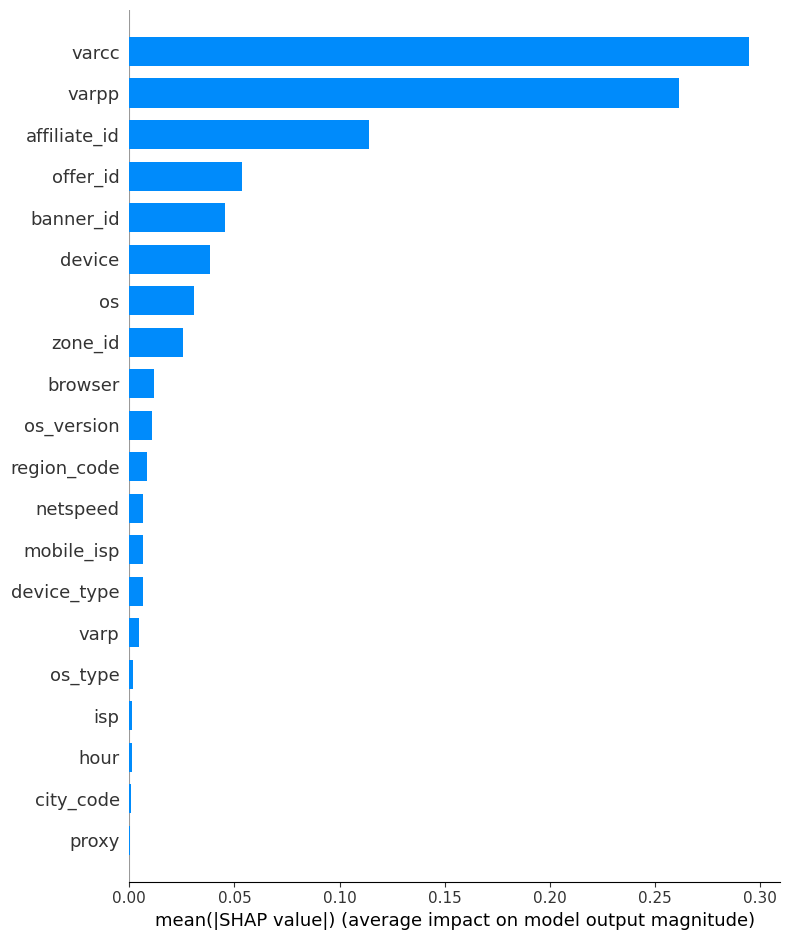

time: 27.7 s (started: 2023-01-21 23:16:19 +04:00)


In [25]:
import shap


def shap_feature_importance(cat_model: CatBoostClassifier, data: pd.DataFrame, model_exclud_columns: List[str]):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(model_exclud_columns, axis=1),
                                                        data[binary_convs_column],
                                                        stratify=data[binary_convs_column],
                                                        test_size=0.2)
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(
        X_train
    )
    shap.summary_plot(shap_values, X_train, plot_type="bar")


shap_feature_importance(naive_model, data, model_exclud_columns)

from the information taken from the trained model the numerical values had the most of importance,\
this is due to non processing of the rest of futures, lets take a deeper look. and look for the feature importance\
using catboost feature recursive selection method

In [26]:
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm


def feature_selection(data: pd.DataFrame, params: dict, testing_cols: List[str], model_exclud_columns: List[str],
                      binary_convs_column: str) -> List[str]:
    X_train, X_test, y_train, y_test = train_test_split(data.drop(model_exclud_columns, axis=1),
                                                        data[binary_convs_column],
                                                        stratify=data[binary_convs_column],
                                                        test_size=0.2)
    cat_model = CatBoostClassifier(**params)
    summary = cat_model.select_features(
        X_train, y_train,
        eval_set=(X_test, y_test),
        features_for_select=testing_cols,
        num_features_to_select=int(len(testing_cols) / 2),
        steps=int(len(testing_cols) / 2),
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False)
    return summary['selected_features_names']


categorical_important_features = feature_selection(data, params, categorical_cols, model_exclud_columns,
                                                   binary_convs_column)

time: 1min 41s (started: 2023-01-21 23:16:47 +04:00)


we do the selection for categorical and integer features separately

In [27]:
ids_important_features = feature_selection(data, params, id_cols, model_exclud_columns, binary_convs_column)

time: 1min 47s (started: 2023-01-21 23:18:29 +04:00)


In [65]:
print(ids_important_features, categorical_important_features)

['banner_id', 'offer_id', 'zone_id', 'affiliate_id'] ['netspeed', 'device_type', 'device', 'browser']
time: 4.91 ms (started: 2023-01-22 20:27:06 +04:00)


we got the important features, one option is to try retrain the model using only important features and drop the rest,\
but let give it a shoot and do some preprocessing by grouping the non important values for each future into one value,\
take a look above to see histogram of feature values effectivness on the conversion 

In [28]:
def data_values_grouping(data: pd.DataFrame, grouping_values: dict, columns: List[str],
                         replace_with: any = -1) -> pd.DataFrame:
    for col in columns:
        if len(grouping_values[col]) > 1:
            if replace_with == -1:
                replace_with = data[col].min()
            data.loc[data[col].isin(grouping_values[col]), col] = replace_with
    return data


data_processed = data.copy()
data_processed = data_values_grouping(data.copy(), grouping_values,
                                      set(categorical_cols) - set(categorical_important_features), 'Grouped_Others')
data_processed = data_values_grouping(data_processed, grouping_values, set(id_cols) - set(ids_important_features))

time: 500 ms (started: 2023-01-21 23:21:28 +04:00)


let also split hours into two values, 1 for night, 0 for day\
and split day into 1 for weekend and 0 for working days

In [29]:
def hours_day_processing(data: pd.DataFrame, hour_column: str, day_column: str) -> pd.DataFrame:
    data.loc[data[hour_column] > 12, hour_column] = 1
    data.loc[data[hour_column] != 1, hour_column] = 0
    data[day_column] = data[day_column].astype(str)
    data.loc[data[day_column].isin(['Saturday', 'Sunday']), day_column] = 1
    data.loc[data[day_column] != 1, day_column] = 0
    data[day_column] = data[day_column].astype(int)
    data[hour_column] = data[hour_column].astype(int)
    return data


data_processed = hours_day_processing(data_processed, hour_column, day_column)

time: 512 ms (started: 2023-01-21 23:21:28 +04:00)


lets train the model again with the prerpocessed data, and see the difference

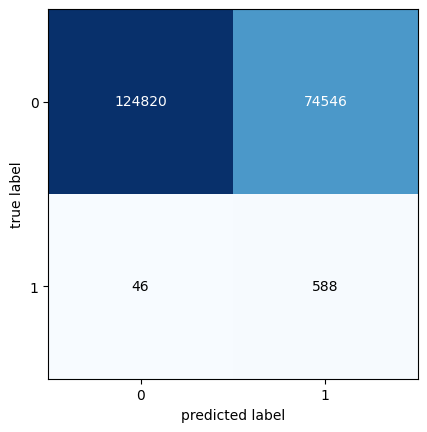

{'learn': {'Logloss': 0.4741207053943402}, 'validation': {'Logloss': 0.4735626125241419, 'AUC': 0.8652929826983715}}
time: 25.6 s (started: 2023-01-21 23:21:29 +04:00)


In [30]:
params_copy = params.copy()
params_copy['cat_features'] = categorical_cols
preprocessed_model = train_evaluate_model(data_processed, params_copy, model_exclud_columns, binary_convs_column)

the AUC metric 0.86 is better then it was 0.75
and loss function 0.47 less then 0.62, 

the schema of future importance changed after preprocessing the features

In [33]:
preprocessed_important_features = get_important_features_list(preprocessed_model,
                                                              data_processed,model_exclud_columns,
                                                              categorical_cols, binary_convs_column)

column: device| importance 0.0
column: geo| importance 0.0
column: lang| importance 0.0
column: os_version| importance 0.0
column: netspeed| importance 2.2710151461083364e-06
column: proxy| importance 0.008305295765694418
column: day| importance 0.07283776201218026
column: os_type| importance 0.12267070323041898
column: os| importance 0.16879214719303617
column: hour| importance 0.19759347542526812
column: mobile_isp| importance 0.1992767185326088
column: banner_id| importance 0.29541326844698806
column: zone_id| importance 0.3126996287524637
column: varp| importance 0.3215354551963478
column: device_type| importance 0.3897742180326379
column: region_code| importance 0.44369474319831764
column: browser| importance 0.5379218945278011
column: offer_id| importance 1.4420523439803785
column: affiliate_id| importance 1.843465796815915
column: isp| importance 3.147826695496313
column: varcc| importance 6.223705948340299
column: varpp| importance 6.331624343972696
column: city_code| importanc

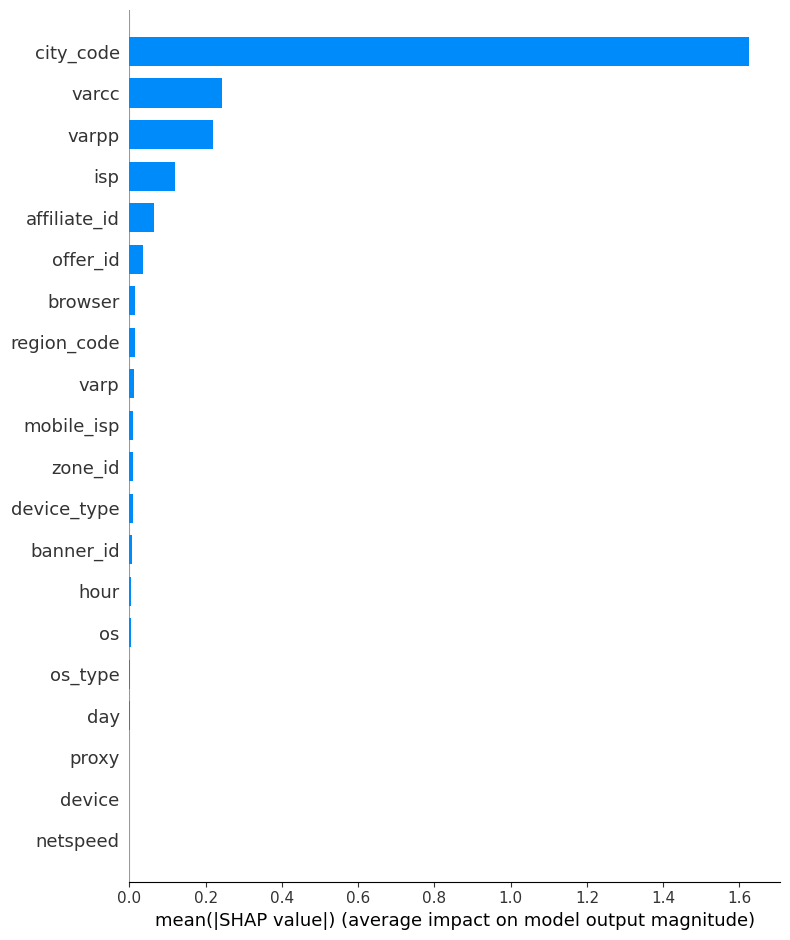

time: 37 s (started: 2023-01-22 20:34:35 +04:00)


In [66]:
shap_feature_importance(preprocessed_model, data_processed, model_exclud_columns)

## model parameters tuning
the model parameters was choosen randomly, lets find the best ones using a set of different choisses

In [40]:
import itertools

processed_model_exclud_columns = list(set(data_processed.columns) - set(preprocessed_important_features))
params_copy['cat_features'] = [col for col in params_copy['cat_features'] if col not in processed_model_exclud_columns]


def parameters_tuning(params: dict, tuning_params: dict, data: pd.DataFrame, model_exclud_columns: List[str],
                      binary_convs_column: str):
    results = []
    all_possible_params = sum([[{k: v} for v in tuning_params[k]] for k in tuning_params], [])
    all_possible_combinations = [i for i in list(itertools.combinations(all_possible_params, len(tuning_params))) if
                                 len(set([list(k.keys())[0] for k in i])) >= len(tuning_params)]
    all_possible_combinations = [{k: v for d in list(i) for k, v in d.items()} for i in all_possible_combinations]
    params_copy=params.copy()
    params_copy['cat_features'] = list(set(categorical_cols) - set(model_exclud_columns))
    best_auc = {'validation': {'AUC': 0}}
    best_loss = {'validation': {'Logloss': 1}}
    for combination in all_possible_combinations:
        params_copy.update(combination)
        preprocessed_model = train_evaluate_model(data, params_copy, model_exclud_columns,
                                                  binary_convs_column, plot=False)
        model_score = preprocessed_model.best_score_
        model_score.update(combination)
        if model_score['validation']['AUC'] > best_auc['validation']['AUC']:
            best_auc = model_score
            print('best by AUC')
            print(model_score)
        if model_score['validation']['Logloss'] < best_loss['validation']['Logloss']:
            best_loss = model_score
            print('best by Logloss')
            print(model_score)
        results.append([model_score])
    return results, best_auc, best_loss


models_parameters, best_auc, best_loss = parameters_tuning(params_copy, {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'l2_leaf_reg': [2, 5, 10],
    'random_strength': [2, 5, 10]}, data_processed, processed_model_exclud_columns, binary_convs_column)

best by AUC
{'learn': {'Logloss': 0.4127873370899093}, 'validation': {'Logloss': 0.41212988687651975, 'AUC': 0.8898854281320999}, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'random_strength': 2}
best by Logloss
{'learn': {'Logloss': 0.4127873370899093}, 'validation': {'Logloss': 0.41212988687651975, 'AUC': 0.8898854281320999}, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'random_strength': 2}
best by AUC
{'learn': {'Logloss': 0.3444542684187286}, 'validation': {'Logloss': 0.40106892854690585, 'AUC': 0.8926320568694877}, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'random_strength': 2}
best by Logloss
{'learn': {'Logloss': 0.3444542684187286}, 'validation': {'Logloss': 0.40106892854690585, 'AUC': 0.8926320568694877}, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'random_strength': 2}
best by AUC
{'learn': {'Logloss': 0.2915105510011608}, 'validation': {'Logloss': 0.39090180812885733, 'AUC': 0.8997802806188995}, 'iterations': 500,

the best model is with ``` Logloss': 0.38046443806441443, 'AUC': 0.9073962529040402 ```
lets train the model to see feature importance and convention matrix

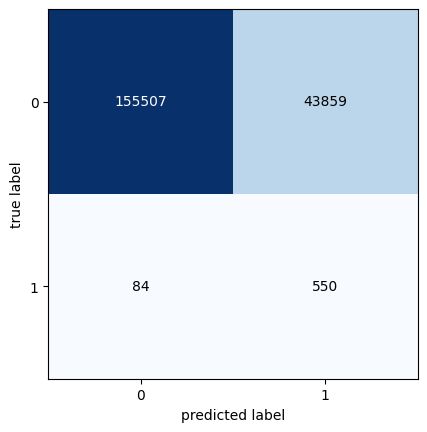

time: 2min 32s (started: 2023-01-22 17:12:02 +04:00)


In [45]:
params_copy = params.copy()
params_copy['cat_features'] = categorical_cols
params_copy.update({k: v for k, v in best_auc.items() if k not in ['learn', 'validation']})
selected_model = train_evaluate_model(data_processed, params_copy,
                                      model_exclud_columns, binary_convs_column, plot=True)

In [48]:
final_important_features = get_important_features_list(selected_model, data_processed, model_exclud_columns,
                                                       categorical_cols, binary_convs_column, thresh=1)

column: proxy| importance 0.02153999560922171
column: hour| importance 0.13419330526641055
column: os| importance 0.35874114821266617
column: os_type| importance 0.3951441058484398
column: varp| importance 0.5237249474323123
column: os_version| importance 0.5644993583733618
column: netspeed| importance 0.5825271850212391
column: device_type| importance 0.821923015140791
column: day| importance 0.876305213014776
column: device| importance 0.9551583657244438
column: mobile_isp| importance 1.1899590074504733
column: browser| importance 1.2998782389448498
column: lang| importance 1.4175404889467527
column: zone_id| importance 2.9914752171218653
column: offer_id| importance 3.6545113915086267
column: geo| importance 4.161759554400567
column: varpp| importance 4.51193687520482
column: affiliate_id| importance 4.971285710707806
column: varcc| importance 5.002576947411695
column: banner_id| importance 5.143839728846208
column: isp| importance 5.14744978946947
column: region_code| importance 8.

## final model training

### feature importance 
with the new values all the features importance are +0,\
lets take the features with more the 1 value of importance and retrain the final model
### potentiel fraud ignoring
lets delete the doubtful rows by taking n_impressions>=n_conversions

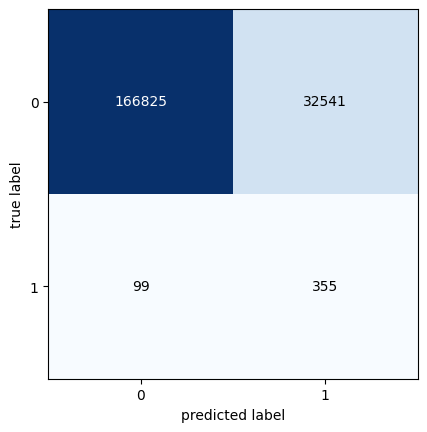

time: 1min 55s (started: 2023-01-22 21:04:21 +04:00)


In [82]:
final_model_exclud_columns = [col for col in data.columns if col not in final_important_features]
final_params = params_copy.copy()
final_params['cat_features'] = list(set(categorical_cols) - set(final_model_exclud_columns))
final_model = train_evaluate_model(data_processed.query(imps_column + '>=' + convs_column), final_params,
                                   final_model_exclud_columns, binary_convs_column, plot=True)

In [83]:
final_model.best_score_

{'learn': {'Logloss': 0.2509592919796602},
 'validation': {'Logloss': 0.3801211387307621, 'AUC': 0.907149673274854}}

time: 7.35 ms (started: 2023-01-22 21:07:08 +04:00)


In [85]:
tp, fp, tn, fn = 166825, 32541, 99, 355
print('accuracy:', (tp + tn) / (tp + tn + fp + fn))
print('precission:', tp / (tp + fp))
print('recall: ', tp / (tp + fn))
print('classification error:', (fp + fn) / (tp + tn + fp + fn))

accuracy: 0.835371834651186
precission: 0.8367775849442733
recall:  0.9978765402560115
classification error: 0.16462816534881394
time: 1.38 ms (started: 2023-01-22 21:07:45 +04:00)


the model with the importante features ``` ['mobile_isp','browser','lang','zone_id','offer_id','geo','varpp','affiliate_id','varcc','banner_id','isp','region_code','city_code']```\
have almost the same performance with model with all features ~0.9 AUC so we can keep the features list/
the false postive rate is less,


In [86]:
final_important_features

['mobile_isp',
 'browser',
 'lang',
 'zone_id',
 'offer_id',
 'geo',
 'varpp',
 'affiliate_id',
 'varcc',
 'banner_id',
 'isp',
 'region_code',
 'city_code']

time: 2.36 ms (started: 2023-01-22 21:08:26 +04:00)
